In [1]:
import numpy as np

from matplotlib import pyplot as plt

from scipy.optimize import minimize
from scipy.interpolate import interp1d


In [2]:
import sys

sys.path.append("/global/homes/s/sfschen/Python/ZeldovichReconPk/")

In [3]:
from zeldovich_rsd_recon_fftw import Zeldovich_Recon

In [4]:
# power spectrum
sys.path.append('/global/homes/s/sfschen/Python/cosmoprimo/')
from cosmoprimo.fiducial import DESI

cosmo = DESI()

pkz = cosmo.get_fourier().pk_interpolator()
pk = pkz.to_1d(z=0.8)

kl = np.logspace(-3,1,2000)
pl = pk(kl)

In [6]:
# Linear Growth
sys.path.append('../')
from lss_likelihood.linear_theory import D_of_a, f_of_a

In [7]:
z = 0.8
OmegaM = cosmo['Omega_m']
fnu = cosmo['Omega_ncdm_tot'] / OmegaM

In [8]:
fz = f_of_a(1/(1+z), OmegaM=OmegaM) * (1-0.6*fnu)

In [9]:
# Run PT class
zelda = Zeldovich_Recon(kl,pl,R=10)

In [10]:
zelda.make_pltable(fz, D=1,\
                   kmin = 1e-3, kmax = 0.5, nk = 400,\
                   ngauss = 4, nmax=8, method = 'RecSym', a_perp = 1, a_par = 1);

In [86]:
def PellTemplates_b2(b1,b2):
    
    p0 = zelda.p0kPellTemplates_b2le[:,0] + b1 * zelda.p0ktable[:,1] + b1**2*zelda.p0ktable[:,2] +\
          b2*zelda.p0ktable[:,3] + b1*b2*zelda.p0ktable[:,4] + b2**2*zelda.p0ktable[:,5]
    p2 = zelda.p2ktable[:,0] + b1 * zelda.p2ktable[:,1] + b1**2*zelda.p2ktable[:,2] +\
          b2*zelda.p2ktable[:,3] + b1*b2*zelda.p2ktable[:,4] + b2**2*zelda.p2ktable[:,5]
    
    return p0, p2

In [12]:
# Fit the data

In [14]:
pkdat = np.loadtxt('../data/pkells_recsym_mean_cubic.dat')
cov   = np.loadtxt('../data/pkells_recsym_cov_cubic.dat')
cinv = np.linalg.inv(cov)

(0.0, 0.3)

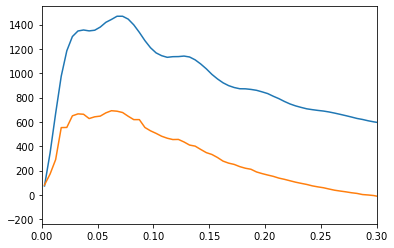

In [15]:
plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,1])
plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,2])

plt.xlim(0,0.3)

In [59]:
kcen = pkdat[:,0]
dk = kcen[1] - kcen[0]
kr = kcen + dk/2
kl = kcen - dk/2
kmean = 3./4 * (kr**4 - kl**4) / (kr**3 - kl**3)

In [120]:
def bf_poly_b2_p0(b1, b2, kmax=0.3):
    
    
    iis = (pkdat[:,0] < kmax) * (pkdat[:,0] > 0.02)
    
    p0, p2 = PellTemplates_b2(b1,b2)
    
    p0 = interp1d(zelda.kv, p0, kind='cubic', bounds_error=False)(kmean)
    
    #diff = np.concatenate((p0,p2)) - np.concatenate( (pkdat[:,1], pkdat[:,2]) )
    
    _func = lambda pcoeffs: np.sum( ((p0 + polyval(kmean/0.1, pcoeffs) / (kmean/0.1)**2 - pkdat[:,1])**2 / pkdat[:,1])[iis]**2 )
    
    x = minimize(_func, [0,0,0,0,0]).x
    
    return x

def bf_poly_b2_p2(b1, b2, kmax=0.3):
    
    
    iis = (pkdat[:,0] < kmax) * (pkdat[:,0] > 0.02)
    
    p0, p2 = PellTemplates_b2(b1,b2)
    
    p2 = interp1d(zelda.kv, p2, kind='cubic', bounds_error=False)(kmean)
    
    #diff = np.concatenate((p0,p2)) - np.concatenate( (pkdat[:,1], pkdat[:,2]) )
    
    _func = lambda pcoeffs: np.sum( ((p2 + polyval(kmean/0.1, pcoeffs) / (kmean/0.1)**2 - pkdat[:,2])**2 / pkdat[:,1])[iis]**2 )
    
    x = minimize(_func, [0,0,0,0,0]).x
    
    return x

(0.0, 2000.0)

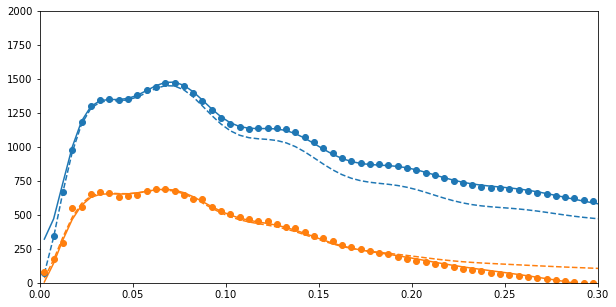

In [144]:
plt.figure(figsize=(10,5))

b1, b2 = 0.984, 0

p0, p2 = PellTemplates_b2(b1,b2)
p0 = interp1d(zelda.kv, p0, kind='cubic', bounds_error=False)(kmean)
p2 = interp1d(zelda.kv, p2, kind='cubic', bounds_error=False)(kmean)


pcoeffs0 = bf_poly_b2_p0(b1,b2)

plt.plot(kcen, kcen * (p0 + polyval(kmean/0.1, pcoeffs0) / (kmean/0.1)**2), 'C0')
plt.plot(kcen, kcen * (p0 + 0*polyval(kmean/0.1, pcoeffs0) / (kmean/0.1)**2), 'C0--')

pcoeffs2 = bf_poly_b2_p2(b1,b2)

plt.plot(kcen, kcen * (p2 + polyval(kmean/0.1, pcoeffs2) / (kmean/0.1)**2), 'C1')
plt.plot(kcen, kcen * (p2 + 0*polyval(kmean/0.1, pcoeffs2) / (kmean/0.1)**2), 'C1--')

#plt.plot(kcen, kcen * p2, 'C1')

plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,1], 'C0o')
plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,2], 'C1o')

plt.xlim(0,0.3)
plt.ylim(0,2000)

In [145]:
ptdat = np.zeros_like(pkdat)
ptdat[:,0] = pkdat[:,0]

for ii, k in enumerate(kcen):
    
    p0, p2 = PellTemplates_b2(b1,b2)
    
    p0 += polyval(zelda.kv/0.1, pcoeffs0) / (zelda.kv/0.1)**2
    p2 += polyval(zelda.kv/0.1, pcoeffs2) / (zelda.kv/0.1)**2
    
    temp0 = interp1d(zelda.kv, p0, kind='cubic', bounds_error=False, fill_value=0)
    temp2 = interp1d(zelda.kv, p2, kind='cubic', bounds_error=False, fill_value=0)
    
    rint = np.arange(0,1.01,0.01) * dk + (k - dk/2)
    
    ptdat[ii,1] = np.trapz(rint**2 * temp0(rint),x=rint) / np.trapz(rint**2, x=rint)
    ptdat[ii,2] = np.trapz(rint**2 * temp2(rint),x=rint) / np.trapz(rint**2, x=rint)

In [147]:
def bin_pk(ptvec):
    
    ptdat = np.zeros_like(pkdat[:,1])
    
    for ii, k in enumerate(kcen):    
        temp0 = interp1d(zelda.kv, ptvec, kind='cubic', bounds_error=False, fill_value=0)
    
        rint = np.arange(0,1.01,0.01) * dk + (k - dk/2)
    
        ptdat[ii] = np.trapz(rint**2 * temp0(rint),x=rint) / np.trapz(rint**2, x=rint)
    
    return ptdat

(0.0, 2000.0)

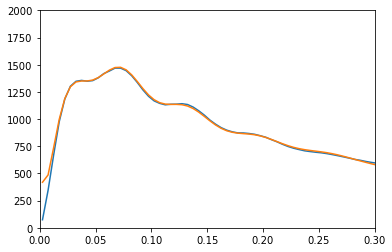

In [149]:
plt.plot(pkdat[:,0], pkdat[:,0] * pkdat[:,1])

p0, p2 = PellTemplates_b2(b1,b2)
p0 += polyval(zelda.kv/0.1, pcoeffs0) / (zelda.kv/0.1)**2
ptdat = bin_pk(p0)

plt.plot(pkdat[:,0], pkdat[:,0] * ptdat)

plt.xlim(0,0.3)

plt.ylim(0,2000)

In [152]:
# Run a few 

for b2 in [-4, -2, -1, -0.5, 0, 0.5, 1, 2, 4]:
    
    b1 = 0.985

    p0, p2 = PellTemplates_b2(b1,b2)

    pcoeffs0 = bf_poly_b2_p0(b1,b2)
    pcoeffs2 = bf_poly_b2_p2(b1,b2)
    
    p0 += polyval(zelda.kv/0.1, pcoeffs0) / (zelda.kv/0.1)**2
    p2 += polyval(zelda.kv/0.1, pcoeffs2) / (zelda.kv/0.1)**2
    
    p0 = bin_pk(p0)
    p2 = bin_pk(p2)
    
    np.savetxt('data/pkells_recsym_theory_b2_%.1f.txt'%(b2), np.array([pkdat[:,0],p0,p2]).T)

In [66]:
from loginterp import loginterp
from spherical_bessel_transform import SphericalBesselTransform as SBT

In [71]:
xidat = np.loadtxt('../data/xiells_recsym_mean_cubic.dat')

In [157]:
kint = zelda.kint
sbt = SBT(kint, fourier=True)

b1, b2 = 0.984, -5

p0, p2 = PellTemplates_b2(b1,b2)

p0 = loginterp(zelda.kv, p0)(kint)
p2 = loginterp(zelda.kv, p2)(kint)

qq0, xi0 = sbt.sph(0, p0 * np.exp(-kint**2))
qq2, xi2 = sbt.sph(2, p2 * np.exp(-kint**2)); xi2 *= -1

(-20.0, 100.0)

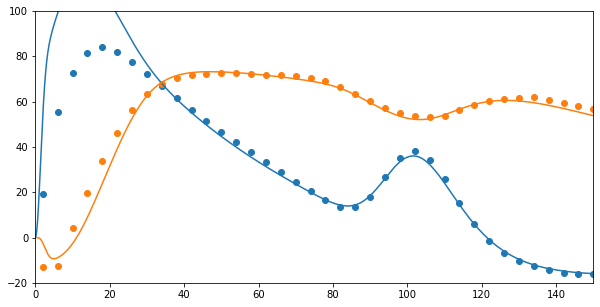

In [158]:
plt.figure(figsize=(10,5))

plt.plot(xidat[:,0], xidat[:,0]**2 * xidat[:,1], 'C0o')
plt.plot(xidat[:,0], -xidat[:,0]**2 * xidat[:,2], 'C1o')

plt.plot(qq0, qq0**2 * xi0)
plt.plot(qq0, -qq0**2 * xi2)

plt.xlim(0,150)
plt.ylim(-20,100)

In [159]:
rth = np.loadtxt('r_theory.txt')
binmat = np.loadtxt('binmat.txt')

In [160]:
for b2 in [-4, -2, -1, -0.5, 0, 0.5, 1, 2, 4]:
    
    b1 = 0.984

    p0, p2 = PellTemplates_b2(b1,b2)

    p0 = loginterp(zelda.kv, p0)(kint)
    p2 = loginterp(zelda.kv, p2)(kint)

    qq0, xi0 = sbt.sph(0, p0 * np.exp(-kint**2))
    qq2, xi2 = sbt.sph(2, p2 * np.exp(-kint**2)); xi2 *= -1

    xtdat = np.zeros_like(xidat)

    xtdat[:,0] = xidat[:,0]
    xtdat[:,1] = np.dot( binmat, interp1d(qq0, xi0, kind='cubic', fill_value=0, bounds_error=False)(rth) ) 
    xtdat[:,2] = np.dot( binmat, interp1d(qq2, xi2, kind='cubic', fill_value=0, bounds_error=False)(rth) )
    
    np.savetxt('data/xiells_recsym_theory_b2_%.1f.txt'%(b2), xtdat)
    
    

In function -  run_code


/global/homes/s/sfschen/Python/ZeldovichReconPk/loginterp.py:28: RuntimeWarning: overflow encountered in power
  yr = y[r]*(xr/x[r])**rneff
/global/homes/s/sfschen/Python/ZeldovichReconPk/loginterp.py:28: RuntimeWarning: overflow encountered in multiply
  yr = y[r]*(xr/x[r])**rneff


In function -  run_code
In function -  run_code
In function -  run_code


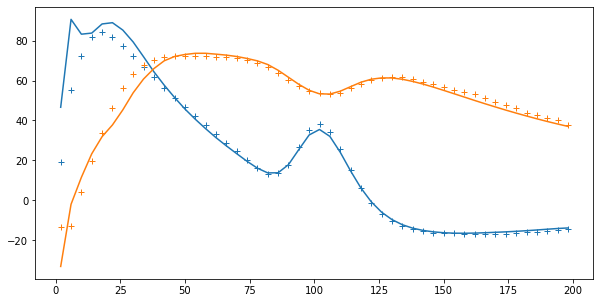

In [161]:
plt.figure(figsize=(10,5))

plt.plot(xidat[:,0], xidat[:,0]**2 * xidat[:,1], 'C0+')
plt.plot(xidat[:,0], xidat[:,0]**2 * xtdat[:,1], 'C0')

plt.plot(xidat[:,0], -xidat[:,0]**2 * xidat[:,2], 'C1+')
plt.plot(xidat[:,0], -xidat[:,0]**2 * xtdat[:,2], 'C1')